In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy import linalg
from numba import njit

On considére dans ce cas l'équation de Burgers avec diffusion non linéaire suivante:
\begin{equation}
    \begin{cases}
    & \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \epsilon \frac{\partial}{\partial x}\left(\left| \frac{\partial u}{\partial x} \right| \frac{\partial u}{\partial x} \right) \quad \text{pour} \quad t > 0, \quad x \in [l, L]\\
    & u(x,0)=u_0(x) \quad \forall x \in [l,L]
    \end{cases}
\end{equation}

In [69]:
" **** Solutions initiales proposées **** "

@njit
def u0(x):
    #Chock & Détente
    if x <= 1 / 4:
        return ul
    if 1 / 4 < x < 3 / 4:
        return um
    else:
        return ur
    


# La Solution Exacte
        
@njit
def Uex(t,x):
    if T<=1/2:
        if x>=0.75 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>0.5 and T<=1:
        if x>=1.2 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>1 and T<=1.8:
        if x>=1.5 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>1.8 and T<=2:
        if x>=1.87 :
            if x-(3/4)<0.5*(um+ur)*t:
                return um
            else:
                return ur
        else:
            if x-(1/4)<= ul*t:
                    return ul

            elif x-(1/4)>ul*t and x-(1/4)< um*t:
                return (x-(1/4))/t
            elif x-(1/4)>=um*t:
                return um
    elif T>2:
        if x-(1/4)<= ul*t:
                return ul

        elif x-(1/4)>ul*t and x-(1/4)< um*t:
            return (x-(1/4))/t
        elif x-(1/4)>=um*t:
            return um
    

@njit
def u0_Gauss(x):
    # Condition initiale gaussienne
    return np.sin(np.pi * x / (L - l)) + 2.5 * (L - l) * np.sin(100 * (L - l) * np.pi * x / (L - l))


" **** Le flux exact **** "
@njit
def F(u):
    return (u**2) / 2

" **** Les flx numériques proposés **** "
@njit
def Rusanov(ug, ud, dx, dt):
    # Flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud)) - lamda * (ud - ug)

@njit
def Rusanov2(ug, ud, dx, dt):
    # Deuxième version du flux numérique Rusanov
    lamda = max(abs(ug), abs(ud))
    return 0.5 * (F(ug) + F(ud) - lamda * (ud - ug))

@njit
def Roe(ug, ud, dx, dt):
    # Flux numérique Roe
    return 0.5 * ((F(ug) + F(ud)) - (ug + ud) / 2 * (ud - ug))

@njit
def LF(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs
    return 0.5 * ((F(ug) + F(ud)) - (dx / dt) * (ud - ug))

@njit
def LFM(ug, ud, dx, dt):
    # Flux numérique Lax-Friedrichs modifié
    return 0.5 * ((F(ug) + F(ud)) - 0.5 * (dx / dt) * (ud - ug))

@njit
def LW(ug, ud, dx, dt):
    # Flux numérique Lax-Wendroff
    A = 0.5 * (ud + ug)
    return 0.5 * (F(ug) + F(ud) - (dt / dx) * A * (F(ud) - F(ug)))


@njit(cache=True)
def depature_fvc_flux(dt,alpha,x,u):
    aux=1
    eps=1e-9
    x0=0.5*(x[0]+x[1])   
    x1=x0
    xmp=x0
    while(aux>eps):
        deriv=np.interp(x0, x, u)
        x1=xmp-dt*alpha*deriv
        aux=np.abs(x0-x1)
        x0=x1
    if x0>x[1]:
        x0=x[1]
    if x0<x[0]:
        x0=x[0]    
    return x0 

 
@njit(cache=True)
def fvc_flux(u,x,dt,alpha):
    
    Alpha = alpha
    x_car = depature_fvc_flux(dt, Alpha,x,  u)

    up   = np.interp(x_car, x, u)
    

    return 0.5 * up**2

@njit
def VFC(U0, T,  N,  alpha, dx, CFL,X):
    Un    = U0.copy()
    Unp1  = np.zeros(N)
    
    temps = 0
    

    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**p)
        max_diff = np.max(absolute_differences)
        
        if epsilon != 0:
            dt1  = CFL * (dx/(np.max(np.abs(Un))*np.sqrt(2*alpha)))
            dt2  = CFL * 0.5 * dx**2 / np.abs(epsilon*max_diff)
            dt   = min(dt1,dt2)
        else:
            if epsilon == 0:
                dt  = CFL * dx / np.max(np.abs(Un))
                
        temps += min(dt,T-dt)
        
        for i in range(1,N-1):
            X1   = [X[i-1],X[i]]
            u1   = [Un[i-1],Un[i]]
            
            X2   = [X[i],X[i+1]]
            u2   = [Un[i],Un[i+1]]
            
            Fg  = fvc_flux(u1,X1,dt,alpha)
            Fd  = fvc_flux(u2,X2,dt,alpha)
            
            FDd = (np.abs((Un[i+1]-Un[i])/dx))**p * (Un[i+1]-Un[i])/dx
            FDg = (np.abs((Un[i]-Un[i-1])/dx))**p * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * dt/dx * (FDd-FDg)
            
        Unp1[0]   = Unp1[1]
        Unp1[N-1] = Unp1[N-2]
        Un = Unp1.copy()
    return Un


@njit
def Solver(U0, epsilon, T, l, L, N, CFL, scheme,p):

    if scheme == 0:
        flux = Roe 
    elif scheme == 1:
        flux = Rusanov
    elif scheme == 2:
        flux = Rusanov2
    elif scheme == 3:
        flux = LW
    elif scheme == 4:
        flux = LFM
    
        
    Un   = U0.copy()
    Unp1 = np.zeros(N)

    temps = 0
    
    while temps < T:
        absolute_differences = np.abs((np.diff(Un)/dx)**p)
        max_diff = np.max(absolute_differences)
        
        if scheme == 0 or scheme == 2 :
            if epsilon != 0 :
                dt  = CFL /(np.max(np.abs(Un))/dx +2*epsilon*np.abs(max_diff)/(dx**2))
            else:
                if epsilon == 0:
                    dt  = CFL * dx / np.max(np.abs(Un))
                
        if scheme == 1 or scheme ==4:
            if epsilon != 0 :
                dt  = CFL/(np.max(np.abs(Un))/dx + epsilon * np.abs(max_diff)/(dx**2))
            else:
                if epsilon == 0:
                    dt  = CFL * dx / np.max(np.abs(Un))
                
        if scheme == 3:
            if epsilon != 0 :
                dt  = CFL /(np.max(np.abs(Un))/dx + 2 * np.abs(epsilon*max_diff)/(dx**2))
            else:
                if epsilon == 0:
                    dt  = CFL * dx / np.max(np.abs(Un))
                
        
            
        
        dt = min(dt, T - temps)
        temps += dt
        
        for i in range(1,N-1):
            Fd = flux(Un[i],Un[i+1],dx,dt)
            Fg = flux(Un[i-1],Un[i],dx,dt)
            FDd = (np.abs((Un[i+1]-Un[i])/dx))**p * (Un[i+1]-Un[i])/dx
            FDg = (np.abs((Un[i]-Un[i-1])/dx))**p * (Un[i]-Un[i-1])/dx

            Unp1[i] = Un[i] - dt / dx * (Fd - Fg) + epsilon * dt/dx * (FDd-FDg)
            
            
        Unp1[0] = Unp1[1]
        Unp1[N-1] = Unp1[N-2]


        Un[:] = Unp1[:]
        

    return Un


##############################################################################################################
ul       =   0.2
um       =   0.8
ur       =   0.4
T        =   1.5
l        =   0
L        =   2
epsilon  =   0.0
N        =   101
CFL      =   0.5
alpha    =   2
X        =   np.linspace(l,L,N)
U0       =   np.array([u0(x) for x in X]) 
p        =   1

dx = (L - l) / (N - 1)




" **** Calcul des solutions approchées **** "

f = {}

fluxes = {("Roe",0):1, ("Rusanov",1):0, ("Rusanov2",2):0, ("LW",3):0,("LFM",4):0 }

for i,j in fluxes.items():  
    if j:
        f[i[0]]  =  Solver  (U0, epsilon, T, l, L, N, CFL, i[1], p)   
    
U_VFC = VFC( U0, T,  N,  alpha, dx, CFL,X)

f['VFC'] = U_VFC

/tmp/ipykernel_4467/3972472592.py:256: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  for i in range(1,N-1):


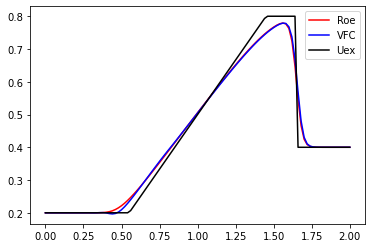

In [70]:
PLOT = {"Roe":1, "Rusanov":1, "Rusanov2":0, "LW":1, "LFM":0, "VFC":1}

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown']

for i, (flux, Un) in enumerate(f.items()) :
    k = list(PLOT)[i]
    if PLOT[k]:
        plt.plot(X, Un, '-', label=flux, color=colors[i])
    

#plt.xlim([1, 1.75])  
#plt.ylim([6, 12]) 

if epsilon == 0 :
    Uexact = np.array([Uex(T,x) for x in X])
    plt.plot(X, Uexact, '-k',  label='Uex')
else:
    plt.plot(X, U0, '-k',  label='U0')
    
    
plt.legend()
plt.pause(0.1)



In [60]:
Norm = {}
for i, (flux, Un) in enumerate(f.items()):
    Norm[flux]    =  np.linalg.norm(Un,ord = 2) 
Norm


{'Roe': 4.533865775248752, 'VFC': 4.537398284512762}